# Lab 2 - Maze Game as a Markov Decision Process Part 1

## **1. Objectives**

In this lab, we will:

- Model a simple **maze game** as a **Markov Decision Process (MDP)** by defining:
  - **States**
  - **Actions**
  - **Transition probabilities**
  - **Rewards**

- Implement **policy evaluation** to compute the value function of a given policy.

This week, we **do not** improve the policy and search for an optimal one yet.  
We will continue working on the Maze Game **next week**, where we will use these components to compute an **optimal policy**.

We consider a **discounted MDP** with discount factor  $\gamma \in (0,1)$.






In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(
    precision=3,
    suppress=True,
)
# (not mandatory) This line is for limiting floats to 3 decimal places,
# avoiding scientific notation (like 1.23e-04) for small numbers.

# For reproducibility
rng = np.random.default_rng(seed=42)  # This line creates a random number generator.

## 2. Maze definition and MDP formulation

We consider a small 2D maze on a grid. The agent is a **robot** that moves on the grid.

- `S` : start state
- `G` : goal state, with positive reward
- `#` : wall (not accessible)
- `.` : empty cell
- `X` : "trap" (negative reward)

At each step, the robot can choose among 4 actions:

$$
\mathcal{A} = \{\text{Up} \uparrow, \quad \text{Right} \rightarrow, \quad \text{Down} \downarrow, \quad \text{Left}\leftarrow\}.
$$

The movement is deterministic, but here we set a small probability of “error” to make the example more realistic.
- With probability $1 - p_{\text{error}}$, it moves in the chosen direction.
- With probability $p_{\text{error}}$, it moves in a random *other* direction.
- If the movement would hit a wall or go outside the grid, the agent stays in place.

We will represent the MDP with:

- A list of **states** $\mathcal{S} = \{0, \dots, n_{S - 1}\}$, **each corresponding to a grid cell.**
- For each action $a$, a transition matrix $P[a]$ of size $(n_S, n_S)$, where
  $$
  P[a][s, s'] = \mathbb{P}(S_{t+1} = s' \mid S_t = s, A_t = a).
  $$
- A reward vector $R$ of length $n_S$, where $R[s]$ is the immediate reward obtained when **leaving** state $s$.

We will use a discount factor $\gamma = 0.95$.


### 2.1 Define the maze 

Let us now define the maze as follows.

In [74]:
maze_str = [
    "#######",
    "S...#.#",
    "#.#...#",
    "#.#..##",
    "#..#..G",
    "#..X..#",
    "#######",
]

**Exercise 1.** Compute the dimensions of the maze (complete the “TO DO” parts):
- How many rows does the maze have?
- How many columns does the maze have?

In [75]:
n_rows = len(maze_str)
print(n_rows)
n_cols = len(maze_str[0])
print(n_cols)

7
7


In [76]:
print("Maze:")
for row in maze_str:
    print(row)

Maze:
#######
S...#.#
#.#...#
#.#..##
#..#..G
#..X..#
#######


### 2.2 Map each walkable cell (not a wall '#') to a state index

Now we convert the maze grid into state indices for the MDP.


The cells where the robot is allowed to stand are 

- . : empty space

- S : start

- G : goal

- X : trap

Everything else (i.e., #) is a wall and cannot be a state in the MDP.


In [77]:
FREE = {
    ".",
    "S",
    "G",
    "X",
}  # The vector Free represents cells that the agent is allowed to move into.

**Dictionaries to convert between grid and state index**

We now want to identify all **valid states** of the maze (all non-wall cells).  
To do this, we need two mappings:

1. `state_to_pos[s] = (i, j)`: Given a state index $s$, return its grid coordinates (row, column).
2. `pos_to_state[(i, j)] = s`: Given coordinates (i, j), return the corresponding state index $s$.

These two dictionaries allow easy conversion between **MDP state indices** and the **physical maze positions**. 

In [ ]:
state_to_pos = {}  # s -> (i,j)
pos_to_state = {}  # (i,j) -> s

start_state = None  # will store the state index of start state
goal_states = []  # will store the state index of goal state
trap_states = []  # will store the state index of trap state

s = 0
for i in range(n_rows):  # i = row index
    for j in range(n_cols):  # j = column index
        cell = maze_str[i][j]  # cell = the character at that position (S, ., #, etc.)

        if cell in FREE:
        # FREE contains: free cells ".", start cell "S", goal cell "G" and trap cell "X"
        # Walls # are ignored, they are not MDP states.
            state_to_pos[s] = (i, j)
            pos_to_state[(i, j)] = s

            if cell == "S":
                start_state = s
            elif cell == "G":
                goal_states.append(s)
            elif cell == "X":
                trap_states.append(s)

            s += 1

n_states = s

print("Number of states (non-wall cells):", n_states)
print("Start state:", start_state, "at", state_to_pos[start_state])
print("Goal states:", goal_states, "at", state_to_pos[goal_states[0]])
print("Trap states:", trap_states, "at", state_to_pos[trap_states[0]])

Number of states (non-wall cells): 22
Start state: 0 at (1, 0)
Goal states: [16] at (4, 6)
Trap states: [19] at (5, 3)


*Hint.* If you don’t know what a dictionary is in Python, try the following code to help you understand.

In [79]:
my_dict = {"key1": "value1", "key2": "value2"}
print(my_dict["key2"])

value2


**Exercise 2.** Read the program above and answer the following questions:
1. What is the purpose of state_to_pos and pos_to_state?
2. Why do we only assign states to cells in FREE?
3. What would happen if the maze had multiple goal cells?
4. What is the total number of states (n_states) in this maze? Does this match the number of non-wall cells you can count visually?

1. What is the purpose of `state_to_pos` and `pos_to_state`? These dictionaries establish a bijective mapping between the mathematical representation of the state and its spatial representation:

    `state_to_pos`: Maps the scalar state index `s` (an integer used for matrix/vector operations in RL algorithms like Q-learning) to the grid coordinates (i,j).

    `pos_to_state`: Maps the grid coordinates (`i,j`) (used to calculate movement and dynamics within the 2D grid) back to the unique state index s.

2. Why do we only assign states to cells in FREE? In a Markov Decision Process (MDP), walls (#) are obstructions, not valid states.

    The agent can never "be" in a wall, so assigning a state index to a wall would needlessly increase the dimensionality of the state space (∣S∣).

    Excluding walls ensures the transition matrices and value vectors remain compact and contain only reachable positions.

3. What would happen if the maze had multiple goal cells?

    In the code: The logic is robust. Since goal_states is initialized as a list (`[]`), the code would simply append the state index `s` of every `G` cell found during the iteration. The list would contain multiple integers representing all terminal states.

    Caveat: While the logic holds, the final print statement in the provided script (`state_to_pos[goal_states[0]]`) would only display the coordinates of the first goal found, ignoring the others in the console output.

4. What is the total number of states (`n_states`) in this maze? Does this match the number of non-wall cells you can count visually?

    `n_states` represents the total count of walkable cells (Start, Goal, Trap, and empty space).

    Yes, this value matches exactly the number of non-wall cells visible in the maze, as the counter s is incremented precisely when a cell is found in the FREE set.

-----

The following function `plot_maze_with_states` creates a figure showing:
- the maze walls and free cells
- the state index for each non-wall cell
- special labels and colors for S (start state), G (goal state), and X (trap state). 

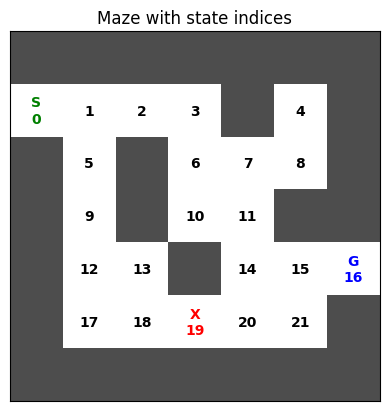

In [ ]:
def plot_maze_with_states() -> None:
    """Plot the maze with state indices."""
    grid = np.ones(
        (n_rows, n_cols),
    )  # Start with a matrix of ones. Here 1 means “free cell”
    for i in range(n_rows):
        for j in range(n_cols):
            if maze_str[i][j] == "#":
                grid[i, j] = 0  # We replace walls (#) with 0

    _fig, ax = plt.subplots()
    ax.imshow(grid, cmap="gray", alpha=0.7)

    # Plot state indices
    for (
        s,
        (i, j),
    ) in state_to_pos.items():
        cell = maze_str[i][j]

        if cell == "S":
            label = f"S\n{s}"
            color = "green"
        elif cell == "G":
            label = f"G\n{s}"
            color = "blue"
        elif cell == "X":
            label = f"X\n{s}"
            color = "red"
        else:
            label = str(s)
            color = "black"

        ax.text(
            j,
            i,
            label,  # Attention : matplotlib, text(x, y, ...) expects (column, row)
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color=color,
        )

    ax.set_xticks([])  # remove numeric axes, we don't need.
    ax.set_yticks([])
    ax.set_title("Maze with state indices")

    plt.show()


plot_maze_with_states()

### 2.4 Actions and deterministic movement

We first define integer codes for each action. 

**Exercise 3.** How many possible actions can the agent take in the maze?

We have four possible actions in the maze. 

In this following cell, each action is mapped to an integer (0,1,2,3). This makes it easy to store and use actions inside arrays and matrices

Here we use Unicode arrow character:

- "\u2191" : ↑ (up arrow)

- "\u2192" : → (right arrow)

- "\u2193" : ↓ (down arrow)

- "\u2190" : ← (left arrow)

In [81]:
A_UP, A_RIGHT, A_DOWN, A_LEFT = 0, 1, 2, 3
ACTIONS = [A_UP, A_RIGHT, A_DOWN, A_LEFT]
action_names = {A_UP: "\u2191", A_RIGHT: "\u2192", A_DOWN: "\u2193", A_LEFT: "\u2190"}

In [82]:
print(action_names[0])

↑


**Exercise 4.** Now we define a **deterministic movement function** `move_deterministic(i, j, a)`. 

This function simulates the robot trying to move from (i, j) in direction a.

But if the movement hits a wall or boundary, the agent stays in place.

In [ ]:
def move_deterministic(i: int, j: int, a: int) -> tuple[int, int]:
    """Deterministic movement on the grid. If the movement hits a wall or boundary, the agent stays in place.

    Args:
        i (int): current row index
        j (int): current column index
        a (int): action to take (A_UP, A_DOWN, A_LEFT, A_RIGHT)

    Returns:
        (tuple[int, int]): new (row, column) position after taking action a

    """
    candidate_i, candidate_j = (
        i,
        j,
    )  # It means “Unless the action succeeds, the robot stays in place.”

    # Now each action changes the coordinates of the robot:
    if a == A_UP:
        candidate_i, candidate_j = (
            i - 1,
            j,
        )  # if the action is UP, then row becomes row -1
    elif a == A_DOWN:
        candidate_i, candidate_j = (
            i + 1,
            j,
        )  # if the action is DOWN, then row becomes row +1
    elif a == A_LEFT:
        candidate_i, candidate_j = (
            i,
            j - 1,
        )  # if the action is LEFT, then column becomes column -1
    elif a == A_RIGHT:
        candidate_i, candidate_j = (
            i,
            j + 1,
        )  # if the action is RIGHT, then column becomes column +1

    # Check boundaries
    if not (0 <= candidate_i < n_rows and 0 <= candidate_j < n_cols):
        # If the robot tries to move outside the maze
        # It will not move and it stays at (i, j).
        return i, j

    # Check wall
    if maze_str[candidate_i][candidate_j] == "#":
        # If the next cell is a wall, the robot stays in place.
        return i, j

    return candidate_i, candidate_j  # Otherwise, return the new position

### 2.5 Transition probabilities and reward function

Recall that we set the discount factor $\gamma \in(0,1)$, that is, the future rewards are multiplied by $\gamma$, so immediate rewards matter a little bit more than future ones. 


Moreover, we consider a probability error $p_{\text{error}}$, which means, with probability $p_{\text{error}}$, the robot **does not** execute the intended action but one of the 3 other directions (chosen uniformly). With probability $1-p_{\text{error}}$, the robot executes the action that we asked.

In [84]:
gamma = 0.95
p_error = 0.1  # probability of the error to a random other direction

Now we initialize the state–transition probability : the probability of reaching next state $s'$ after taking action $a$ in state $s$. 
$$
        p(s' \mid s, a)
        = \mathbb{P} \big[S_t=s'\,|\, S_{t-1}=s, \,A_{t-1}=a\big]
$$

We store these transition probabilities in the 3D array `P` (`P[a][s, s_next]`), which has shape `(n_actions, n_states, n_states)`:

`P[a, s, s_next] = P(S_{t+1} = s_next | S_t = s, A_t = a)`.

We also initialize the reward vector `R`, which has length `n_states`, where `R[s]` is the reward received when the agent is in state `s`.

In this maze game, we assume that the reward depends only on the current state, which is natural: in navigation tasks, being in a particular location is what matters, not the direction you used to reach it.

In [85]:
# Initialize transition matrices and reward vector
P = np.zeros((len(ACTIONS), n_states, n_states))
R = np.zeros(n_states)

Now we assign the reward to each state. 

For each state index s:

1. If s is a goal, then the reward = +1.0
2. If s is a trap, then the reward = −1.0
3. Otherwise for the normal cell, the reward = −0.01 every time you leave this cell.

Recall that rewards are received at the moment the agent executes an action. Here when the agent moves out of the cell, we set reward −0.01. 

In [86]:
# Set rewards for each state
step_penalty = -0.01
goal_reward = 1.0
trap_reward = -1.0

**Exercise 5.** Why do we set the step penalty to -0.01 in this MDP?

We set a small negative step penalty (`-0.01`) for two main reasons:

- Incentivize Efficiency: It forces the agent to find the shortest path to the goal. By losing a small amount of reward at every step, the agent learns that the faster it reaches the goal, the higher its total cumulative return will be.

- Prevent Loitering: It discourages infinite loops or wandering. Without this penalty (i.e., if step reward = 0), the agent might be indifferent between reaching the goal now or in 1000 steps, potentially leading to a policy that never terminates.

**Exercise 6.** We now define the reward vector. Recall that we have already initialized
`R = np.zeros(n_states)`.
If a state belongs to `goal_states`, we assign the `goal_reward`.
If it belongs to `trap_states`, we assign the `trap_reward`.
Otherwise, we assign the `step_penalty`. 

In [87]:
for s in range(n_states):
    if s in goal_states:
        R[s] = goal_reward
    elif s in trap_states:
        R[s] = trap_reward
    else:
        R[s] = step_penalty

Now we define terminal states and a helper function. Here terminal_states is a set containing all absorbing states, which means, reaching them ends the episode conceptually. 

Moreover, `is_terminal(s)` is a small helper to check if a state is terminal.

In [88]:
terminal_states = set(goal_states + trap_states)


def is_terminal(s: int) -> bool:
    """Check if a state is terminal (goal or trap)."""
    return s in terminal_states

Now we need to fill the transition matrices `P[a][s, s_next]`. 


**Exercise 7.** **Complete the `# TO DO` part in the program below** to fill the transition matrices `P[a][s, s_next]`. 

In [89]:
for s in range(n_states):  # We loop over all states s.
    i, j = state_to_pos[
        s
    ]  # We recover the states to their coordinates (i, j) in the maze.

    # First, in a goal or trap state,
    # No matter which action you “choose”, you stay in the same state with probability 1.
    # This makes the terminal states as the absorbing states.
    if is_terminal(s):
        # Terminal states: stay forever
        for a in ACTIONS:
            P[a, s, s] = goal_reward
        continue

    # If the state is non-terminal, we define the stochastic movement.
    # For a given state s and intended action a,
    # With probability 1 - p_error, the robot will move in direction a;
    # With probability p_error, the robot will move in one of the other 3 directions, each with probability p_error / 3.
    for a in ACTIONS:
        # main action (intended action)
        main_i, main_j = move_deterministic(i, j, a)
        s_main = pos_to_state[
            (main_i, main_j)
        ]  # s_main is the state index of that next cell.
        P[a, s, s_main] += (
            1 - p_error
        )  # We add probability 1 - p_error to P[a, s, s_main].

        # error actions
        other_actions = [
            a2 for a2 in ACTIONS if a2 != a
        ]  # other_actions = the 3 actions different from a.
        for a2 in other_actions:  # for each of the error action,
            error_i, error_j = move_deterministic(i, j, a2)
            s_error = pos_to_state[(error_i, error_j)]  # get its state index s_error
            P[a, s, s_error] += p_error / len(
                other_actions,
            )  # add p_error / 3 to P[a, s, s_error]
# So for each (s,a), probabilities over all s_next sum to 1.

Now we check if the transition matrices `P[a][s, s_next]` are computed correctly.
For each action `a`, we sum the transition probabilities over all possible next states `s_next` and verify that these sums are equal to 1.

This is because the matrix `P[a, s, s_next]` stores the transition probability

$\mathbb{P} \big[S_t=s_{\text{next}}\,|\, S_{t-1}=s, \,A_{t-1}=a\big]$. 

Therefore, for each action $a$, and for each state $s$, the sum over $s_{\text{next}}$ of $\mathbb{P} \big[S_t=s_{\text{next}}\,|\, S_{t-1}=s, \,A_{t-1}=a\big]$ should be 1. 

In [90]:
for a in ACTIONS:
    # For each action a:
    # P[a] is a matrix of shape (n_states, n_states).
    # P[a].sum(axis=1) sums over next states s_next, giving for each state s:
    # We print these row sums.
    # If everything is correct, they should be very close to 1.

    probs = P[a].sum(axis=1)
    print(f"Action {action_names[a]}:", probs)

Action ↑: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action →: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action ↓: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action ←: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 3. Policy evaluation

### 3.1 Bellman expectation equation

Recall that the value function under a policy $\pi$ is defined as:
$$
V^{\pi}(s)=\mathbb{E}\Big[\:G_t \:\Big|\: S_t=s\:\Big]
$$
where the return $G_t$ is
$$
G_t=R_t +\gamma R_{t+1}+\gamma^2 R_{t+2}+... . 
$$
This means *The value of a state is the expected discounted sum of all future rewards
when following policy $\pi$.*

We know that $G_t=R_t+\gamma G_{t+1}$, and plugging this equation into the definition of $V^{\pi}(s)$, we get 
$$
V^{\pi}(s)=\mathbb{E}\Big[\:R_t \:\Big|\: S_t=s\:\Big]+\gamma\mathbb{E}\Big[\:G_{t+1} \:\Big|\: S_t=s\:\Big]. 
$$
This step shows simply ``The total future reward = immediate reward + discounted reward from next state.''

For the expected immediate reward part $\mathbb{E}[R_t| S_t=s]$, as we are in a maze problem, the reward depends only on the current state, not the time step, i.e., $\mathbb{E}[R_t| S_t=s]=R(s)$. Hence we get 
$$
V^{\pi}(s)=R(s)+\gamma\mathbb{E}\Big[\:G_{t+1} \:\Big|\: S_t=s\:\Big]. 
$$

Moreover, in this maze problem, we consider a deterministic policy $A_t=\pi(s)$ (the action depends only on the state). Therefore, 
$$
V^{\pi}(s)=\mathbb{E}\Big[\:R_t \:\Big|\: S_t=s\:\Big]+\gamma\mathbb{E}\Big[\:G_{t+1} \:\Big|\: S_t=s, A_t=\pi(s)\:\Big]. 
$$

Now **given the state $S_t=s$ and $A_t=a$**, the next state is random (because of the error probability) and we know the transition probability 
$$
\mathbb{P}\big(\:S_{t+1}=s' \:|\:S_t=s, \, A_t=a\big)=P\big(s'\:\big|\:s, a\big). 
$$

Therefore,
$$
\mathbb{E}\big[\,G_{t+1}\,|\,S_t=s,A_t=a\,\big] =\sum_{s'}\mathbb{E}\big[\,G_{t+1}\,|\,S_{t+1}=s'\,\big]\times \mathbb{P}\big[S_{t+1}=s'\,\big|\,S_t=s, A_t=a\, \big]
$$
$$
\hspace{-1.2cm}=\sum_{s'}V^{\pi}(s')P\big(s'\:\big|\:s, a\big),
$$
where here we use the Markov property. (**Question: Can you show the detailed computations here?**)

In conclusion, we have (the Bellman expectation equation)
$$
V^{\pi}(s)=R(s)+\gamma \sum_{s'}P\big(\,s'\,\big|\,s, \pi(s)\,\big)V^{\pi}(s').
$$

### 3.2 Define a function which computes the value function $V^{\pi}(s)$ for a given deterministic policy. 


**Exercise $8^*$.** Now we define `policy_evaluation(...)`, which computes the value function $V^{\pi}(s)$ for a given deterministic policy. 

The input of this function `policy_evaluation(...)` are:
1. policy: array of size `n_states`, each entry is an action 0,1,2,3, which correspond to UP, RIGHT, DOWN, LEFT.
2. `P`: the transition probabilities `P[a, s, s']`.
3. `R`: the reward vector `R[s]`.
4. gamma: the discount factor $\gamma\in(0,1)$.
5. theta: convergence threshold.
6. max_iter: which is used to avoid infinite loops.

How can we apply the Bellman expectation equation
$$
V^{\pi}(s)=R(s)+\gamma \sum_{s'}P\big(\,s'\,\big|\,s, \pi(s)\,\big)V^{\pi}(s').
$$
here ?



We start with an initial guess of $V^{\pi}$(e.g., all values = 0) and repeatedly apply the Bellman equation to update each state:
$$
V_{k+1}^\pi(s) \leftarrow R(s)+\gamma \sum_{s'}P\big(\,s'\,\big|\,s, \pi(s)\,\big)V^{\pi}_k(s').
$$
until values converge.

In [ ]:
def policy_evaluation(  # noqa: PLR0913
    policy: np.ndarray,
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 10_000,
) -> np.ndarray:
    """Evaluate a deterministic policy for the given MDP.

    Args:
        policy: array of shape (n_states,), with values in {0,1,2,3}
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor
        theta: convergence threshold
        max_iter: maximum number of iterations

    """
    n_states = len(R)  # get the number of states
    V = np.zeros(n_states)  # initialize the value function

    for _it in range(max_iter):  # Main iterative loop
        V_new = np.zeros_like(
            V,
        )  # Create a new value vector and we will compute an updated value for each state.

        # Now we update each state using the Bellman expectation equation
        for s in range(n_states):
            a = policy[s]  # Extract the action chosen by the policy in state
            V_new[s] = R[s] + gamma * np.sum(P[a, s, :] * V)

        delta = np.max(
            np.abs(V_new - V),
        )  # This measures how much the value function changed in this iteration:
        # If delta is small, the values start to converge; otherwise, we need to keep iterating.
        V = V_new  # Update V, i.e. Set the new values for the next iteration.

        if delta < theta:  # Check convergence: When changes are tiny, we stop.
            break

    return V  # Return the final value function, this is our estimate for V^{pi}(s), s in the state set.

### 3.3 Evaluating a random policy

Now we use the policy evaluation function `policy_evaluation` to evaluate a random policy. 

We first generate a `random_policy`, which is an array like [2, 0, 1, 3, 0, 2, ...] and has the size `n_states`. (Recall that the policy is a mapping from states to actions).

In [92]:
# Random policy: for each state, pick a random action
random_policy = rng.integers(low=0, high=len(ACTIONS), size=n_states)

print(random_policy)

[0 3 2 1 1 3 0 2 0 0 2 3 2 3 2 3 2 0 3 1 2 1]


Now we call the function `policy_evaluation(...)` to compute $V^{\pi_{\text{random}}}(s)$.

In [93]:
V_random = policy_evaluation(policy=random_policy, P=P, R=R, gamma=gamma)
print("Value function under random policy:")
print(V_random)

Value function under random policy:
[ -0.2    -0.2    -0.201  -0.204  -0.205  -0.202  -0.214  -0.429  -0.212
  -0.207  -0.276  -0.459  -0.352  -0.366  -5.827  -4.605  20.     -0.366
  -0.999 -20.     -6.4    -3.163]


Here in this value vector of the policy, 
- If it is a negative values, then the agent tends to move around aimlessly, fall in traps, or take too long.
- It it is a higher values, then the agent is closer to the goal or more likely to reach it

Now we define a function `plot_values`, which displays the value function $V(s)$ and displays it on the maze grid. It helps students visually understand:
- which states are good (high value, near the goal),
- which states are bad (low value, near traps),
- how a policy affects the long-term expected reward.

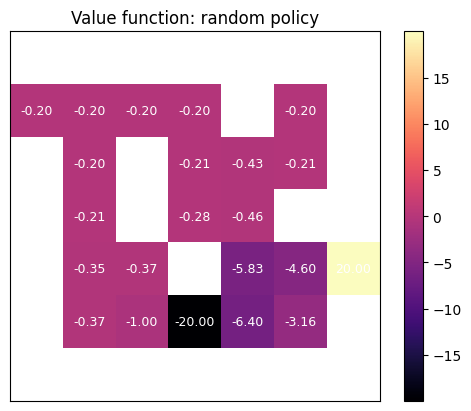

In [ ]:
def plot_values(V: np.ndarray, title: str = "Value function") -> None:
    """Plot the value function V on the maze as a heatmap."""
    grid_values = np.full(
        (n_rows, n_cols),
        np.nan,
    )  # Initializes a grid the same size as the maze. Every cell starts as NaN.
    for (
        s,
        (i, j),
    ) in (
        state_to_pos.items()
    ):  # recall that state_to_pos maps each state index to its maze coordinates (i,j).
        grid_values[i, j] = V[
            s
        ]  # For each reachable cell, we write the value V[s] in the grid.
        # Walls # never get values, and they stay as NaN.

    _fig, ax = plt.subplots()
    im = ax.imshow(grid_values, cmap="magma")
    plt.colorbar(im, ax=ax)

    # For each state:
    # Place the text label at (column j, row i).
    # Display value to two decimals.
    # Use white text so it's visible on the heatmap.
    # Center the text inside each cell.

    for s, (i, j) in state_to_pos.items():
        ax.text(
            j,
            i,
            f"{V[s]:.2f}",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )

    # Remove axis ticks and set title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()


plot_values(V_random, title="Value function: random policy")

The next function `plot_policy` visualizes a policy on the maze.


In [ ]:
def plot_policy(policy: np.ndarray, title: str ="Policy") -> None:
    """Plot the given policy on the maze."""
    _fig, ax = plt.subplots()
    # draw walls as dark cells
    wall_grid = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            if maze_str[i][j] == "#":
                wall_grid[i, j] = 1
    ax.imshow(wall_grid, cmap="Greys", alpha=0.5)

    for s, (i, j) in state_to_pos.items():
        cell = maze_str[i][j]
        if cell == "#":
            continue

        if s in goal_states:
            ax.text(
                j,
                i,
                "G",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="blue",
            )
        elif s in trap_states:
            ax.text(
                j,
                i,
                "X",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="red",
            )
        elif s == start_state:
            ax.text(
                j,
                i,
                "S",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="green",
            )
        else:
            a = policy[s]
            ax.text(
                j,
                i,
                action_names[a],
                ha="center",
                va="center",
                fontsize=14,
                color="black",
            )

    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(visible=True)
    ax.set_title(title)
    plt.show()

Now let’s visualize the `random_policy`. Does it seem like a good policy?

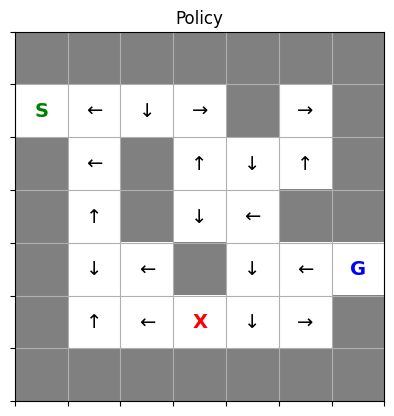

In [96]:
plot_policy(policy=random_policy, title="Policy")

**Exercise 9.** Define your own policy and evaluate it using the functions `policy_evaluation(...)` and `plot_values(...)`. **Can you identify an optimal policy visually?**  Plot your own policy using `plot_policy`. 


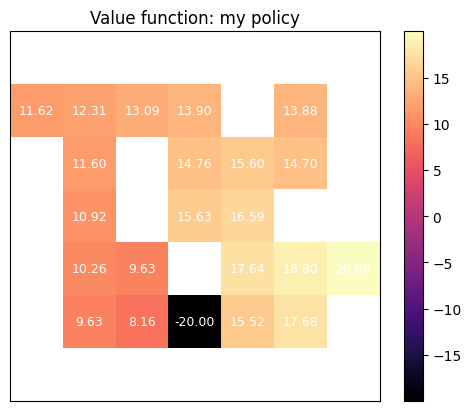

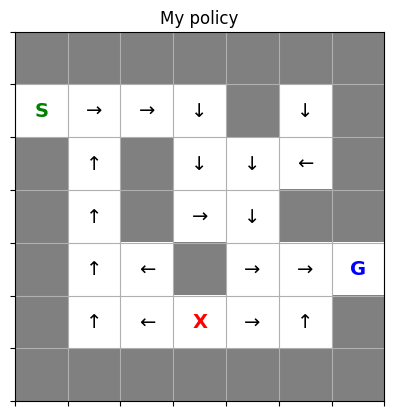

In [ ]:
my_policy = np.ndarray(
    [
        A_RIGHT,
        A_RIGHT,
        A_RIGHT,
        A_DOWN,
        A_DOWN,  # First row
        A_UP,
        A_DOWN,
        A_DOWN,
        A_LEFT,  # Second row
        A_UP,
        A_RIGHT,
        A_DOWN,  # Third row
        A_UP,
        A_LEFT,
        A_RIGHT,
        A_RIGHT,
        A_RIGHT,  # Fourth row
        A_UP,
        A_LEFT,
        A_DOWN,
        A_RIGHT,
        A_UP,  # Fifth row
    ],
)

V_my_policy = policy_evaluation(policy=my_policy, P=P, R=R, gamma=gamma)

plot_values(V=V_my_policy, title="Value function: my policy")
plot_policy(policy=my_policy, title="My policy")


**Exercise 10.** (optional) How can we find an optimal policy?
(We will discuss this question next week, but you can already start thinking about it!)

To find an optimal policy $π^*$ (a policy that yields the highest possible expected return from every state), we generally use one of two main dynamic programming algorithms:

1. **Policy Iteration**: This method alternates between two steps until convergence:

- *Policy Evaluation*: Calculate the value function Vπ(s) for the current specific policy (as we did in Exercise 8).

- *Policy Improvement*: Update the policy to be greedy with respect to the current values. For every state s, we choose the action a that maximizes the expected next value:
        $$π_{new}​(s) = argmax​_{a} \sum_{s\prime} ​P({s \prime}∣s,a)[R(s)+ \gamma V_{\pi}({s\prime})]$$

1. **Value Iteration**: Instead of evaluating a specific policy until convergence every time, we iteratively update the value function directly using the *Bellman Optimality Equation*:
    $$V_{k+1}​(s) = max_a ​(R(s)+ \gamma \sum_{s\prime} ​P(s\prime∣s,a)V_k​(s\prime))$$

    Once the values converge to the optimal values $V^{*}$, we simply extract the optimal policy by acting greedily towards those values.